based on https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=kYcc7uVJfz4D

## Import package

In [2]:
import sys
sys.path.append("/home/ids/gpeeters/proj_audiodataset/")
import audio_dataset as audiodataset

from importlib import reload
reload(audiodataset);

In [3]:
import librosa
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

import IPython.display

import h5py
import pprint as pp

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning.pytorch as pl
import torch.optim as optim

import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger
import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Get datasets

In [4]:
hdf5_audio_file='/tsi/data_doctorants/gpeeters/_data/sol.hdf5'
hdf5_audio_file='/tsi/data_doctorants/gpeeters/_data/rwc-pop.hdf5'

with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    print(len(hdf5_fid.keys()))

train_set = audiodataset.AudioDataset(hdf5_audio_file, True)
valid_set = audiodataset.AudioDataset(hdf5_audio_file, False)

# --- (channel=1, freq=N/2+1, patch=1)
nb_dim = train_set[0]['X'].size(1)
N = 2*(nb_dim-1)
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

100
['RM-P001.wav', 'RM-P002.wav', 'RM-P003.wav', 'RM-P004.wav', 'RM-P005.wav', 'RM-P006.wav', 'RM-P007.wav', 'RM-P008.wav', 'RM-P009.wav', 'RM-P010.wav', 'RM-P011.wav', 'RM-P012.wav', 'RM-P013.wav', 'RM-P014.wav', 'RM-P015.wav', 'RM-P016.wav', 'RM-P017.wav', 'RM-P018.wav', 'RM-P019.wav', 'RM-P020.wav', 'RM-P021.wav', 'RM-P022.wav', 'RM-P023.wav', 'RM-P024.wav', 'RM-P025.wav', 'RM-P026.wav', 'RM-P027.wav', 'RM-P028.wav', 'RM-P029.wav', 'RM-P030.wav', 'RM-P031.wav', 'RM-P032.wav', 'RM-P033.wav', 'RM-P034.wav', 'RM-P035.wav', 'RM-P036.wav', 'RM-P037.wav', 'RM-P038.wav', 'RM-P039.wav', 'RM-P040.wav', 'RM-P041.wav', 'RM-P042.wav', 'RM-P043.wav', 'RM-P044.wav', 'RM-P045.wav', 'RM-P046.wav', 'RM-P047.wav', 'RM-P048.wav', 'RM-P049.wav', 'RM-P050.wav', 'RM-P051.wav', 'RM-P052.wav', 'RM-P053.wav', 'RM-P054.wav', 'RM-P055.wav', 'RM-P056.wav', 'RM-P057.wav', 'RM-P058.wav', 'RM-P059.wav', 'RM-P060.wav', 'RM-P061.wav', 'RM-P062.wav', 'RM-P063.wav', 'RM-P064.wav', 'RM-P065.wav', 'RM-P066.wav', 'RM-P

RM-P003.wav
RM-P004.wav
RM-P005.wav
RM-P007.wav
RM-P008.wav
RM-P009.wav
RM-P010.wav
RM-P012.wav
RM-P013.wav
RM-P014.wav
RM-P015.wav
RM-P017.wav
RM-P018.wav
RM-P019.wav
RM-P020.wav
RM-P022.wav
RM-P023.wav
RM-P024.wav
RM-P025.wav
RM-P027.wav
RM-P028.wav
RM-P029.wav
RM-P030.wav
RM-P032.wav
RM-P033.wav
RM-P034.wav
RM-P035.wav
RM-P037.wav
RM-P038.wav
RM-P039.wav
RM-P040.wav
RM-P042.wav
RM-P043.wav
RM-P044.wav
RM-P045.wav
RM-P047.wav
RM-P048.wav
RM-P049.wav
RM-P050.wav
RM-P052.wav
RM-P053.wav
RM-P054.wav
RM-P055.wav
RM-P057.wav
RM-P058.wav
RM-P059.wav
RM-P060.wav
RM-P062.wav
RM-P063.wav
RM-P064.wav
RM-P065.wav
RM-P067.wav
RM-P068.wav
RM-P069.wav
RM-P070.wav
RM-P072.wav
RM-P073.wav
RM-P074.wav
RM-P075.wav
RM-P077.wav
RM-P078.wav
RM-P079.wav
RM-P080.wav
RM-P082.wav
RM-P083.wav
RM-P084.wav
RM-P085.wav
RM-P087.wav
RM-P088.wav
RM-P089.wav
RM-P090.wav
RM-P092.wav
RM-P093.wav
RM-P094.wav
RM-P095.wav
RM-P097.wav
RM-P098.wav
RM-P099.wav
RM-P100.wav
['RM-P001.wav', 'RM-P002.wav', 'RM-P003.wav', 'RM-P0

## Get model

### Below are test of Conv2D and ConvTranspose2D to check the resulting output size

Text(0.5, 1.0, 'hat_X2')

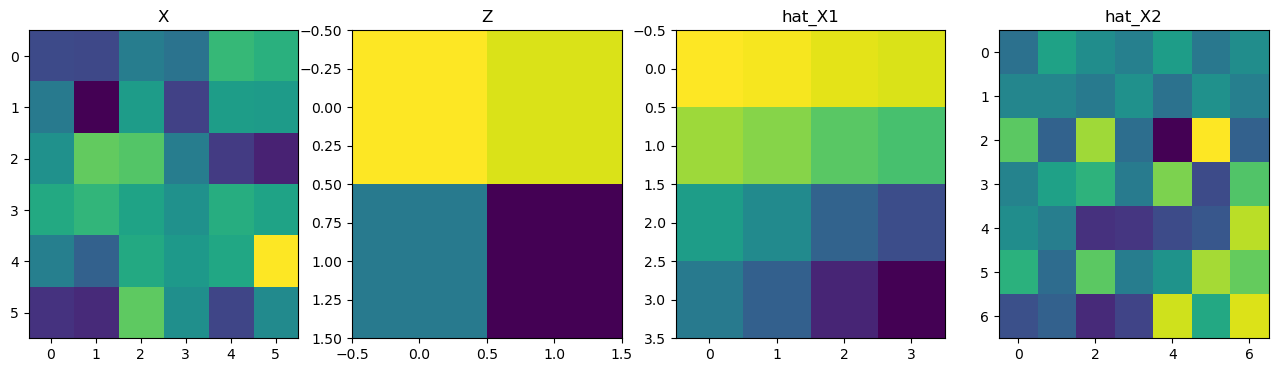

In [5]:
torch.manual_seed(0)

X = torch.randn(1,1,6,6)

Z = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,5), stride=(1,1), padding=0),
              ) (X)
hat_X1 = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), stride=(1,1), padding=0),
                )(Z)
hat_X2 = nn.Sequential(
                nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(5,5), stride=(2,2), padding=0)
                )(Z)

plt.figure(figsize=(16,4))
plt.subplot(141); plt.imshow(X[0,0,:,:].numpy(), aspect='auto'); plt.title('X')
plt.subplot(142); plt.imshow(Z[0,0,:,:].detach().numpy(), aspect='auto'); plt.title('Z')
plt.subplot(143); plt.imshow(hat_X1[0,0,:,:].detach().numpy(), aspect='auto'); plt.title('hat_X1')
plt.subplot(144); plt.imshow(hat_X2[0,0,:,:].detach().numpy(), aspect='auto'); plt.title('hat_X2')

In [6]:
def tlog(x): 
    return torch.log(1+100*x)/10
def untlog(x):
    return (torch.exp(x)-1)/100

In [7]:
def F_check_kernel_size(in_HW, kernel_hw, stride_hw):
    """
    2024-06-21: bug quand on fait le decoder avec les memes parameters que l'encoder on a pas les memes sizes -> c'est du au fait que sans padding quand on fait un stride on peut ne pas aller jusqu'au bout quand H-in-h est impair à cause du floor
    in case convolution w/o padding, check that the kernel_size and stride used does not remove information at the border (see Notes)
    """
    in_H = in_HW[0]
    k_h = kernel_hw[0] # --- kernel h
    s_h = stride_hw[0] # --- stride h
    out_H = (in_H-k_h)/s_h + 1
    comment = '' if out_H.is_integer() else '!!!!!!!!!!!!!'
    print(f'\tin_H: {in_H} k_h: {k_h} s_h: {s_h} \t\t out_H: ({in_H}-{k_h})/{s_h}+1={out_H} {comment}')

    in_W = in_HW[1]
    k_w = kernel_hw[1] # --- kernel h
    s_w = stride_hw[1] # --- stride h
    out_W = (in_W-k_w)/s_w + 1
    comment = '' if out_W.is_integer() else '!!!!!!!!!!!!!'
    print(f'\tin_W: {in_W} k_h: {k_w} s_h: {s_w} \t\t out_W: ({in_W}-{k_w})/{s_w}+1={out_W} {comment}')

### Dephtwise separable

In [8]:
# --- https://github.com/seungjunlee96/Depthwise-Separable-Convolution_Pytorch
# --- https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec
class depthwise_conv(nn.Module): 

    def __init__(self, nin, kernels_per_layer): 
        super(depthwise_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=3, padding=1, groups=nin) 

    def forward(self, x): 
        out = self.depthwise(x) 
        return out

class pointwise_conv(nn.Module):

    def __init__(self, nin, nout): 
        super(pointwise_conv, self).__init__() 
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1) 

    def forward(self, x): 
        out = self.pointwise(x) 
        return out
  
class depthwise_separable_conv(nn.Module):
    
    def __init__(self, nin, kernels_per_layer, nout): 
        super(depthwise_separable_conv, self).__init__() 
        self.depthwise = nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=3, padding=1, groups=nin) 
        self.pointwise = nn.Conv2d(nin * kernels_per_layer, nout, kernel_size=1) 

    def forward(self, x):
        out = self.depthwise(x) 
        out = self.pointwise(out) 
        return out

model = depthwise_separable_conv(16, 1, 32)
X = torch.randn(2,16,23,23)
model(X).size()

torch.Size([2, 32, 23, 23])

In [9]:
# --- EfficientNet https://arxiv.org/pdf/1905.11946

In [10]:
# --- ConvNext https://github.com/gemelo-ai/vocos/blob/main/vocos/modules.py


### ResNet

In [11]:
# --- https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# --- https://gist.github.com/bmabir17/990762d11cd587c05ddfa211d07829b6

class ResBLock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
    
        super(ResBLock, self).__init__()
        self.conv11 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
        
        self.conv1 = nn.Sequential(
             nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(),
             )

        self.conv2 = nn.Sequential(
             nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
             nn.BatchNorm2d(out_channels),
             )
        
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = self.conv11(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        out = self.relu(out)
    
        return out

model = ResBLock(16, 32).to(device)
#print(model)
#X = torch.randn(2, 16, 32, 32)
#model(X)
from torchsummary import summary
#! pip install torchinfo
#import torchinfo
summary(model, input_size=(16, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             544
            Conv2d-2           [-1, 32, 32, 32]           4,640
       BatchNorm2d-3           [-1, 32, 32, 32]              64
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
Total params: 14,560
Trainable params: 14,560
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 1.75
Params size (MB): 0.06
Estimated Total Size (MB): 1.87
----------------------------------------------------------------


### Encoder

In [35]:
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, conv_size, pool_size):
        """
        """
        super(EncoderBlock, self).__init__()
        self.encoder_block = nn.Sequential(
                    nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=conv_size, padding='same'), 
                    nn.BatchNorm2d(out_c),
                    nn.ELU(),
                    nn.MaxPool2d(kernel_size=pool_size)
                  )
        self.encoder_block1 = nn.Sequential(
                    nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=conv_size, stride=pool_size), 
                    nn.BatchNorm2d(out_c),
                    nn.ELU(),
                  )

    def forward(self, X):
        """
        """
        
        return self.encoder_block1(X)

class Encoder(nn.Module):
    def __init__(self, n_c, do_verbose=False):
        """
        """
        super(Encoder, self).__init__()
        self.do_verbose = do_verbose
        self.all_encoder_block = nn.ModuleList([
            EncoderBlock(1, n_c, (11,5), (2,2)), 
            EncoderBlock(n_c, 2*n_c, (11,5), (4,2)), 
            EncoderBlock(2*n_c, 4*n_c, (11,5), (4,2)), 
            EncoderBlock(4*n_c, 8*n_c, (11,5), (4,2)), 
            EncoderBlock(8*n_c, 8*n_c, (11,5), (4,2)), 
            ])
        self.all_encoder_block1 = nn.ModuleList([
            EncoderBlock(1, n_c, (4,4), (2,2)), 
            EncoderBlock(n_c, 2*n_c, (5,5), (2,2)), 
            EncoderBlock(2*n_c, 4*n_c, (4,4), (2,2)), 
            EncoderBlock(4*n_c, 8*n_c, (4,2), (2,1)), 
            EncoderBlock(8*n_c, 16*n_c, (4,1), (2,1)), 
            EncoderBlock(16*n_c, 32*n_c, (4,1), (2,1)), 
            EncoderBlock(32*n_c, 64*n_c, (6,1), (2,1)), 
            ])

    def forward(self, X):
        """
        """
        # --- X (BCWH)
        if self.do_verbose: print(f'encoder: {X.size()}')
        for idx, encoder_block in enumerate(self.all_encoder_block1):
            if self.do_verbose: F_check_kernel_size(X.size()[2:], encoder_block.encoder_block1[0].kernel_size, encoder_block.encoder_block1[0].stride)
            X = encoder_block(X)
            if self.do_verbose: print(f'\tencoder {idx}: {X.size()}')
        return X

model_e = Encoder(n_c=8, do_verbose=True).to(device)
X = torch.randn(2,1,512,32)
z = model_e(X.to(device))
#from torchsummary import summary
#summary(model_e, input_size=(1, 512, 32))


encoder: torch.Size([2, 1, 512, 32])
	in_H: 512 k_h: 4 s_h: 2 		 out_H: (512-4)/2+1=255.0 
	in_W: 32 k_h: 4 s_h: 2 		 out_W: (32-4)/2+1=15.0 
	encoder 0: torch.Size([2, 8, 255, 15])
	in_H: 255 k_h: 5 s_h: 2 		 out_H: (255-5)/2+1=126.0 
	in_W: 15 k_h: 5 s_h: 2 		 out_W: (15-5)/2+1=6.0 
	encoder 1: torch.Size([2, 16, 126, 6])
	in_H: 126 k_h: 4 s_h: 2 		 out_H: (126-4)/2+1=62.0 
	in_W: 6 k_h: 4 s_h: 2 		 out_W: (6-4)/2+1=2.0 
	encoder 2: torch.Size([2, 32, 62, 2])
	in_H: 62 k_h: 4 s_h: 2 		 out_H: (62-4)/2+1=30.0 
	in_W: 2 k_h: 2 s_h: 1 		 out_W: (2-2)/1+1=1.0 
	encoder 3: torch.Size([2, 64, 30, 1])
	in_H: 30 k_h: 4 s_h: 2 		 out_H: (30-4)/2+1=14.0 
	in_W: 1 k_h: 1 s_h: 1 		 out_W: (1-1)/1+1=1.0 
	encoder 4: torch.Size([2, 128, 14, 1])
	in_H: 14 k_h: 4 s_h: 2 		 out_H: (14-4)/2+1=6.0 
	in_W: 1 k_h: 1 s_h: 1 		 out_W: (1-1)/1+1=1.0 
	encoder 5: torch.Size([2, 256, 6, 1])
	in_H: 6 k_h: 6 s_h: 2 		 out_H: (6-6)/2+1=1.0 
	in_W: 1 k_h: 1 s_h: 1 		 out_W: (1-1)/1+1=1.0 
	encoder 6: torch.Size([

### Decoder

In [15]:
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, conv_size, unpool_size, last=False):
        """
        """
        super(DecoderBlock, self).__init__()
        self.block = nn.Sequential(
                    nn.Upsample(mode='bilinear', scale_factor=unpool_size),
                    nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=conv_size, padding='same'),
                    nn.BatchNorm2d(out_c),
                    nn.Sigmoid() if last else nn.ELU(),
                  )

        self.block1 = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=in_c, out_channels=out_c, kernel_size=conv_size, stride=unpool_size),
                    nn.BatchNorm2d(out_c),
                    nn.Sigmoid() if last else nn.ELU(),
                  )

    def forward(self, X):
        """
        """
        return self.block1(X)


class Decoder(nn.Module):
    def __init__(self, n_c, do_verbose=False):
        """
        """
        super(Decoder, self).__init__()
        self.do_verbose = do_verbose
        self.allblock = nn.ModuleList([
            DecoderBlock(8*n_c, 8*n_c, (7,7), (4,2)), 
            DecoderBlock(8*n_c, 4*n_c, (7,7), (4,2)), 
            DecoderBlock(4*n_c, 2*n_c, (7,7), (4,2)), 
            DecoderBlock(2*n_c, n_c, (7,7), (4,2)), 
            DecoderBlock(n_c, 1, (7,7), (2,2), True), 
            ])

        self.allblock1 = nn.ModuleList([
            DecoderBlock(64*n_c, 32*n_c, (6,1), (2,1)), 
            DecoderBlock(32*n_c, 16*n_c, (4,1), (2,1)), 
            DecoderBlock(16*n_c, 8*n_c, (4,1), (2,1)), 
            DecoderBlock(8*n_c, 4*n_c, (4,2), (2,1)), 
            DecoderBlock(4*n_c, 2*n_c, (4,4), (2,2)), 
            DecoderBlock(2*n_c, 1*n_c, (5,5), (2,2)), 
            DecoderBlock(n_c, 1, (4,4), (2,2)), 
            ])
    
    def forward(self, X):
        """
        """
        # --- X (BCWH)
        if self.do_verbose: print(f'decoder: {X.size()}')
        for idx, block in enumerate(self.allblock1):
            X = block(X)
            if self.do_verbose: print(f'\tdecoder {idx}: {X.size()}')
        #X = F.pad(X, (0,0,1,0), 'constant', 0)
        X.add_(1)
        return X



model_d = Decoder(n_c=8, do_verbose=True).to(device)
model_d(z);
#from torchsummary import summary
#summary(model_d, input_size=(256, 1, 1))

decoder: torch.Size([2, 512, 1, 1])
	decoder 0: torch.Size([2, 256, 6, 1])
	decoder 1: torch.Size([2, 128, 14, 1])
	decoder 2: torch.Size([2, 64, 30, 1])
	decoder 3: torch.Size([2, 32, 62, 2])
	decoder 4: torch.Size([2, 16, 126, 6])
	decoder 5: torch.Size([2, 8, 255, 15])
	decoder 6: torch.Size([2, 1, 512, 32])


### Auto-encoder

In [36]:
class ModelAE(nn.Module):
    """
    """
    def __init__(self, n_c=8, do_verbose=False):
        super(ModelAE, self).__init__()
        self._encoder = Encoder(n_c, do_verbose)
        self._decoder = Decoder(n_c, do_verbose)
    def forward(self, X):
        z = self._encoder(X)
        hat_X = self._decoder(z)
        return hat_X, z
    
model_ae = ModelAE(n_c=4, do_verbose=False).to(device)

from torchsummary import summary
summary(model_ae, input_size=(1, 512, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 255, 15]              68
       BatchNorm2d-2           [-1, 4, 255, 15]               8
               ELU-3           [-1, 4, 255, 15]               0
      EncoderBlock-4           [-1, 4, 255, 15]               0
            Conv2d-5            [-1, 8, 126, 6]             808
       BatchNorm2d-6            [-1, 8, 126, 6]              16
               ELU-7            [-1, 8, 126, 6]               0
      EncoderBlock-8            [-1, 8, 126, 6]               0
            Conv2d-9            [-1, 16, 62, 2]           2,064
      BatchNorm2d-10            [-1, 16, 62, 2]              32
              ELU-11            [-1, 16, 62, 2]               0
     EncoderBlock-12            [-1, 16, 62, 2]               0
           Conv2d-13            [-1, 32, 30, 1]           4,128
      BatchNorm2d-14            [-1, 32

### Test model

In [37]:
X = tlog(next(iter(train_loader))['X'])

X: torch.Size([64, 1, 513, 32]) hat_X: torch.Size([64, 1, 512, 32]) z: torch.Size([64, 256, 1, 1])
0.2561226189136505


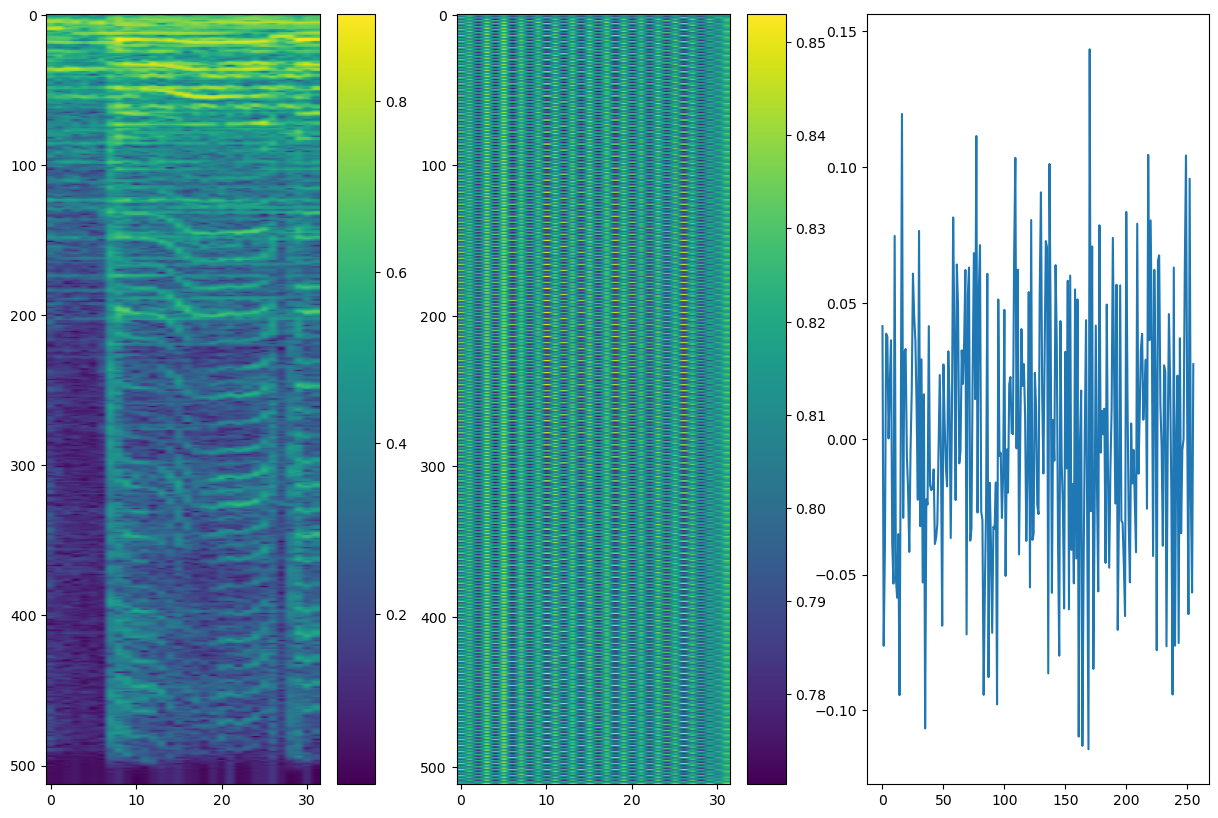

In [38]:
model_ae.eval()
# --- B C H W
hat_X, z = model_ae(X.to(device))
print(f'X: {X.size()} hat_X: {hat_X.size()} z: {z.size()}')

idx = 1
plt.subplot(131); plt.imshow(X[idx,0,:,:].cpu().numpy(), aspect='auto'); plt.colorbar();
plt.subplot(132); plt.imshow(hat_X[idx,0,:,:].cpu().detach().numpy(), aspect='auto'); plt.colorbar();
plt.subplot(133); plt.plot(z[0,:,0,0].cpu().detach().numpy());

criterion = nn.MSELoss().to(device)
loss = criterion(hat_X[idx,:,:,], X[idx,:,:-1,:].to(device))
print(loss.item())

## Train model

In [39]:
model_ae = ModelAE(n_c=16, do_verbose=False).to(device)

In [24]:
from tqdm import tqdm

#criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.01)

print(len(train_loader))
num_epochs = 100


for epoch in range(num_epochs):
        model_ae.train()
        running_loss = 0.0
        with tqdm(train_loader) as pbar:
            for idx, batch in enumerate(pbar):
                pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")
                X = tlog(batch['X']).to(device)
                hat_X, _  = model_ae(X)
                loss = criterion(hat_X, X[:,:,:-1,:])

                # ============ Backward ============
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # ============ Logging ============
                running_loss += loss.data
                pbar.set_postfix(loss=running_loss.item() / (idx + 1))



1615


Epoch 1/100:   4%|▍         | 71/1615 [00:01<00:35, 43.49it/s, loss=0.226]

Epoch 4/100:  24%|██▍       | 392/1615 [00:09<00:29, 41.40it/s, loss=0.00661]


KeyboardInterrupt: 

## TODO: VAE

## TO CLEAN: VQ-VAE part

based on https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb

In [5]:
# residual_layers_innerdim -> residual_dim
# residual_layers_outdim -> hidden_dim should be equal to in_channels

class Residual(nn.Module):
    def __init__(self, in_channels, residual_layers_outdim, residual_layers_innerdim):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=residual_layers_innerdim,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=residual_layers_innerdim,
                      out_channels=residual_layers_outdim,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, residual_layers_outdim, residual_layers_nb, residual_layers_innerdim):
        super(ResidualStack, self).__init__()
        self._residual_layers_nb = residual_layers_nb
        self._layers = nn.ModuleList([Residual(in_channels, residual_layers_outdim, residual_layers_innerdim)
                             for _ in range(self._residual_layers_nb)])

    def forward(self, x):
        for i in range(self._residual_layers_nb):
            x = self._layers[i](x)
        return F.relu(x)

In [11]:
class Encoder(nn.Module):
    def __init__(self, in_channels, residual_layers_outdim, residual_layers_nb, residual_layers_innerdim):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=residual_layers_outdim//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=residual_layers_outdim//2,
                                 out_channels=residual_layers_outdim,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=residual_layers_outdim,
                                 out_channels=residual_layers_outdim,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=residual_layers_outdim,
                                             residual_layers_outdim=residual_layers_outdim,
                                             residual_layers_nb=residual_layers_nb,
                                             residual_layers_innerdim=residual_layers_innerdim)

    def forward(self, inputs):
        print(f'encoder/input: {inputs.shape}')
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        x = self._residual_stack(x)
        print(f'encoder/output: {x.shape}')
        return x

In [12]:
class Decoder(nn.Module):
    def __init__(self, in_channels, residual_layers_outdim, residual_layers_nb, residual_layers_innerdim):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=residual_layers_outdim,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=residual_layers_outdim,
                                             residual_layers_outdim=residual_layers_outdim,
                                             residual_layers_nb=residual_layers_nb,
                                             residual_layers_innerdim=residual_layers_innerdim)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=residual_layers_outdim, 
                                                out_channels=residual_layers_outdim//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=residual_layers_outdim//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        print(f'decoder/input: {inputs.shape}')
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        x = self._conv_trans_2(x)
        print(f'decoder/output: {x.shape}')
        return x

In [13]:
class VectorQuantizer(nn.Module):
    def __init__(self, vq_embedding_nb, vq_embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._vq_embedding_dim = vq_embedding_dim
        self._vq_embedding_nb = vq_embedding_nb
        
        self._embedding = nn.Embedding(self._vq_embedding_nb, self._vq_embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._vq_embedding_nb, 1/self._vq_embedding_nb)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        print(f'vq/inputs: {inputs.shape}')
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        print(f'vq/inputs: {inputs.shape}')
        # Flatten input
        flat_input = inputs.view(-1, self._vq_embedding_dim)
        print(f'vq/flat_input: {flat_input.shape}')
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
        print(f'vq/distances: {distances.shape}')
        
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        print(f'vq/encoding_indices: {encoding_indices.shape}')
        encodings = torch.zeros(encoding_indices.shape[0], self._vq_embedding_nb, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        print(f'vq/encodings: {encodings.shape}')
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        print(f'vq/quantized: {quantized.shape}')
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [14]:
class Model(nn.Module):
    def __init__(self, residual_layers_outdim, residual_layers_nb, residual_layers_innerdim, vq_embedding_nb, vq_embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, residual_layers_outdim, residual_layers_nb, residual_layers_innerdim)
        self._pre_vq_conv = nn.Conv2d(in_channels=residual_layers_outdim, out_channels=vq_embedding_dim, kernel_size=1, stride=1)
        self._vq_vae = VectorQuantizer(vq_embedding_nb, vq_embedding_dim, commitment_cost)
        self._decoder = Decoder(vq_embedding_dim, residual_layers_outdim, residual_layers_nb, residual_layers_innerdim)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [15]:
from argparse import Namespace


batch_size = 256
num_training_updates = 15000

residual_layers_outdim = 128
residual_layers_innerdim = 32
residual_layers_nb = 2

vq_embedding_dim = 64 # --- dimension of each quantizer
vq_embedding_nb = 512 # --- number of quantizers

commitment_cost = 0.25

decay = 0 #0.99

learning_rate = 1e-3

model = Model(residual_layers_outdim, residual_layers_nb, residual_layers_innerdim, vq_embedding_nb, vq_embedding_dim, commitment_cost, decay).to(device)

#from torchsummary import summary
#summary(model, input_size=(3, 32, 32))

X = torch.randn(6, 3, 32, 32).to(device)
model( X )

encoder/input: torch.Size([6, 3, 32, 32])
encoder/output: torch.Size([6, 128, 8, 8])
vq/inputs: torch.Size([6, 64, 8, 8])
vq/inputs: torch.Size([6, 8, 8, 64])
vq/flat_input: torch.Size([384, 64])
vq/distances: torch.Size([384, 512])
vq/encoding_indices: torch.Size([384, 1])
vq/encodings: torch.Size([384, 512])
vq/quantized: torch.Size([6, 8, 8, 64])


(tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[[-0.0219, -0.0390, -0.0387,  ..., -0.0381, -0.0402, -0.0242],
           [-0.0113, -0.0526, -0.0305,  ..., -0.0420, -0.0290, -0.0291],
           [-0.0217, -0.0254, -0.0168,  ..., -0.0262, -0.0146, -0.0065],
           ...,
           [-0.0130, -0.0526, -0.0239,  ..., -0.0434, -0.0250, -0.0281],
           [-0.0237, -0.0315, -0.0165,  ..., -0.0332, -0.0192, -0.0066],
           [-0.0180, -0.0218, -0.0369,  ..., -0.0233, -0.0369, -0.0198]],
 
          [[ 0.1140,  0.1016,  0.1180,  ...,  0.1054,  0.1171,  0.1062],
           [ 0.1163,  0.1078,  0.1286,  ...,  0.1102,  0.1260,  0.1123],
           [ 0.1133,  0.1000,  0.1152,  ...,  0.1009,  0.1249,  0.1048],
           ...,
           [ 0.1179,  0.1084,  0.1304,  ...,  0.1115,  0.1259,  0.1137],
           [ 0.1126,  0.1068,  0.1151,  ...,  0.1101,  0.1180,  0.1058],
           [ 0.1272,  0.1141,  0.1156,  ...,  0.1143,  0.1177,  0.1133]],
 
          [[-0.0282, -0.0171

## Torchlightning

In [27]:
train_config_d = {}
project_name = 'vq-vae'
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
expe_name = formatted_datetime
print(expe_name)
WORK_DIR = './'
wandb.finish()
wandb_logger = WandbLogger(project = project_name, name = expe_name, save_dir = WORK_DIR )
wandb_logger.experiment.config.update(train_config_d)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


2024-09-02-15-37-18


wandb: Currently logged in as: geoffroy-peeters (adasp). Use `wandb login --relogin` to force relogin


In [28]:
class LitAE(pl.LightningModule):
    """
    """
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        #self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()

    def training_step(self, batch, batch_idx):
        """ 
        """
        X = tlog(batch['X'])
        hat_X, _  = self.model(X)
        loss1 = self.criterion(hat_X, X[:,:,:-1,:])
        #print(f'X: {X.min().item()} hat_X: {hat_X.min().item()}')
        loss2 = 1/5*self.criterion(torch.log(hat_X+1e-6), torch.log(X[:,:,:-1,:]+1e-6))
        loss = loss1 + loss2
        self.log("train_loss1", loss1, prog_bar=False)
        self.log("train_loss2", loss2, prog_bar=False)
        self.log("train_loss", loss, prog_bar=False)
        if batch_idx==0: 
            data_image = np.hstack( (X[0,0,:-1,:].cpu().numpy(),  hat_X[0,0,:,:].detach().cpu().numpy()) )
            wandb.log({'train/ae': wandb.Image( data_image )})

        return loss

    def validation_step(self, batch, batch_idx):
        """ 
        """
        X = tlog(batch['X'])
        hat_X, _ = self.model(X)
        loss = self.criterion(hat_X, X[:,:,:-1,:])
        
        self.log("valid_loss", loss, prog_bar=False)
        if batch_idx==0: 
            data_image = np.hstack( (X[0,0,:-1,:].cpu().numpy(),  hat_X[0,0,:,:].detach().cpu().numpy()) )
            wandb.log({'val/ae': wandb.Image( data_image )})

    def configure_optimizers(self):
        """ 
        """
        optimizer = optim.Adam(self.parameters(), 0.01)
        return optimizer



In [29]:
model_ae = ModelAE(n_c=32, do_verbose=False).to(device)
lit_ae = LitAE(model_ae)
trainer = pl.Trainer(accelerator="gpu", 
                     logger = wandb_logger,
                     max_epochs = 500)
trainer.fit(model=lit_ae, train_dataloaders=train_loader, val_dataloaders=valid_loader)

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 5:  25%|██▍       | 399/1615 [00:05<00:16, 75.99it/s, v_num=bftb] 

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
